In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [7]:
import string

def process_text(file_path):
    # Step 1: Read the file and store each line in a list
    with open(file_path, "r", encoding="utf8") as file:
        lines = [line.strip() for line in file]

    # Step 2: Combine all lines into a single string
    data = ' '.join(lines)

    # Step 3: Remove unwanted characters (\n, \r, \ufeff)
    data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')


    # Step 4: Remove duplicate words and join back into a string
    unique_words = []
    for word in data.split():
        if word not in unique_words:
            unique_words.append(word)
    data = ' '.join(unique_words)

    return data

file_path = "/content/metamorphosis_clean.txt"
cleaned_data = process_text(file_path)
print(cleaned_data)


One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. “What’s happened me?” thought. It wasn’t dream. room, proper human room although too small, peacefully between its four familiar walls. A collection textile samples spread out table—Samsa travelling salesman—and above there hung picture that had recently cut an illustrated magazine housed nice, gilded frame. showed lady fitted fur hat boa who sat upright, raising heavy muff covered whole her lower arm towards viewer. then turned look window at dull weather. Drops rain be heard hitting pane, which made him feel quite sad. “How I sleep bit longer forget all this nonsense”,

In [8]:
def save_tokenizer(cleaned_data, tokenizer_file='tokenizer1.pkl'):
    # Tokenize the data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([cleaned_data])

    # Save the tokenizer using pickle
    with open(tokenizer_file, 'wb') as file:
        pickle.dump(tokenizer, file)

    # Convert text to sequences
    sequence_data = tokenizer.texts_to_sequences([cleaned_data])[0]
    vocab_size = len(tokenizer.word_index) + 1

    return sequence_data  , vocab_size

In [9]:
sequence_data,vocab_size = save_tokenizer(cleaned_data)

In [10]:
sequences = []

# Iterate over the indices of sequence_data, creating pairs of consecutive words
for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]  # Create a pair of consecutive words
    sequences.append(words)  # Append the pair to the sequences list

print("The Length of sequences are: ", len(sequences))

sequences = np.array(sequences)  # Convert sequences to a numpy array
sequences[:10]


The Length of sequences are:  4010


array([[  8,  33],
       [ 33, 272],
       [272,  16],
       [ 16,  34],
       [ 34, 725],
       [725, 108],
       [108, 726],
       [726, 273],
       [273,  35],
       [ 35, 727]])

In [11]:
X_train = []
Y_train = []

# Iterate through each pair of consecutive words (sequences)
for i in sequences:
    X_train.append(i[0])  # Append the first word of the pair to X (input)
    Y_train.append(i[1])  # Append the second word of the pair to y (output)

X_train = np.array(X_train)  # Convert X to a numpy array
Y_train = np.array(Y_train)  # Convert y to a numpy array


In [12]:
Y_train[:5]

array([ 33, 272,  16,  34, 725])

In [13]:
# Convert y to categorical format
Y_train = to_categorical(Y_train, num_classes=vocab_size)

# Print the first 5 elements of y after conversion
print(Y_train[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
model = Sequential()

# Add an Embedding layer
# vocab_size: Number of unique tokens in your vocabulary
# 10: Dimensionality of the embedding space
# input_length: Length of input sequences (in this case, 1 as we're predicting one word at a time)
model.add(Embedding(vocab_size, 10, input_length=1))

# Add the first LSTM layer
# 1000: Number of units (or neurons) in the LSTM layer
# return_sequences=True: Return the full sequence of outputs for each timestep
model.add(LSTM(1000, return_sequences=True))

# Add the second LSTM layer
# 1000: Number of units (or neurons) in the LSTM layer
# By default, return_sequences=False, so it outputs the last output in the output sequence
model.add(LSTM(1000))

# Add a Dense layer with 1000 units and 'relu' activation function
model.add(Dense(1000, activation="relu"))

# Add a Dense layer with vocab_size units and 'softmax' activation function
# This layer is the output layer that predicts the probability distribution over the vocabulary
model.add(Dense(vocab_size, activation="softmax"))



In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             28000     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2800)              2802800   
                                                                 
Total params: 15879800 (60.58 MB)
Trainable params: 15879800 (60.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
pip install keras

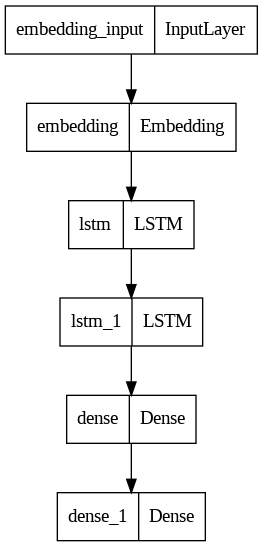

In [16]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is already defined as per your previous code snippet
plot_model(model, to_file='model.png', show_layer_names=True)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

In [19]:
model.fit(X_train, Y_train, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 7.9435
Epoch 1: loss improved from inf to 7.94354, saving model to nextword1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 25s 323ms/step - loss: 7.9435 - lr: 0.0010
Epoch 2/150
63/63 [==============================] - ETA: 0s - loss: 7.9235
Epoch 2: loss improved from 7.94354 to 7.92354, saving model to nextword1.h5
63/63 [==============================] - 20s 312ms/step - loss: 7.9235 - lr: 0.0010
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 7.8847
Epoch 3: loss improved from 7.92354 to 7.88472, saving model to nextword1.h5
63/63 [==============================] - 19s 297ms/step - loss: 7.8847 - lr: 0.0010
Epoch 4/150
63/63 [==============================] - ETA: 0s - loss: 7.6992
Epoch 4: loss improved from 7.88472 to 7.69918, saving model to nextword1.h5
63/63 [==============================] - 20s 316ms/step - loss: 7.6992 - lr: 0.0010
Epoch 5/150
63/63 [==============================] - ETA: 0s - loss: 7.5035
Epoch 5: loss improved from 7.69918 to 7.50355, saving model to nextword1.h5
63/63 [==============================] - 19s 303ms/s